In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC
import econml
import importlib
import pyreadr

import tqdm

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [2]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].drop(columns=["edu", "mar"])
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
# ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
#     int
# )
# ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
#     int
# )

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

df_tedsa_cc = df_tedsa[common_cols].drop(columns=["edu", "mar"])
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Male",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        # "mar": "Married",
        # "edu": "Education(12y)",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

(1271, 11)


Impute Y(t) \
Model P(Y(1),Y(0),X) using KDE \
Logistic regression to model P(S=1 | X), \
Logistic regression to model P(T=1 | X, S=1) \
P( Y=1 | T, X, S=1 ): Option 1 - Logistic Regression

In [11]:
np.random.seed(42)
y1_m = en.GradientBoostingClassifier(n_estimators=10000).fit(
    X.loc[(S == 1) * (T == 1)], Y.loc[(S == 1) * (T == 1)]
)
y0_m = en.GradientBoostingClassifier(n_estimators=10000).fit(
    X.loc[(S == 1) * (T == 0)], Y.loc[(S == 1) * (T == 0)]
)

In [274]:
np.random.seed(42)
joint = X.copy(deep=True)
joint["Y(1)"] = np.random.binomial(1, y1_m.predict_proba(X)[:, 1])
joint["Y(0)"] = np.random.binomial(1, y0_m.predict_proba(X)[:, 1])
# [
#     Y.loc[i]
#     if (T.loc[i] == 1 and S.loc[i] == 1)
#     else np.random.binomial(1, y1_m.predict_proba(X.loc[[i]])[0, 1])
#     for i in tqdm.tqdm(Y.index)
# ]
# joint["Y(0)"] = [
#     Y.loc[i]
#     if (T.loc[i] == 0 and S.loc[i] == 1)
#     else np.random.binomial(1, y0_m.predict_proba(X.loc[[i]])[0, 1])
#     for i in tqdm.tqdm(Y.index)
# ]

In [7]:
joint = pd.read_csv("synth_train_joint.csv", index_col=0)
# P(X,Y(1),Y(0))
pjoint = KernelDensity(kernel="gaussian", bandwidth=2).fit(joint)
# P(S=1 | X)
pi_m = lm.LogisticRegressionCV().fit(X, S)
# P(T=1 | X, S=1)
e_m = lm.LogisticRegressionCV().fit(X.loc[S == 1], T.loc[S == 1])

In [3]:
# P(S=1 | X)
pi_m = SVC(probability=True, kernel="rbf").fit(X, S)
pi_predict = pi_m.predict(X)
pi_score = pi_m.score(X, S)

In [8]:
pi_proba = pd.DataFrame(pi_m.predict_proba(X)[:, 1], index=X.index, columns=["pi"])
pi_proba["S"] = S

<Axes: xlabel='S', ylabel='pi'>

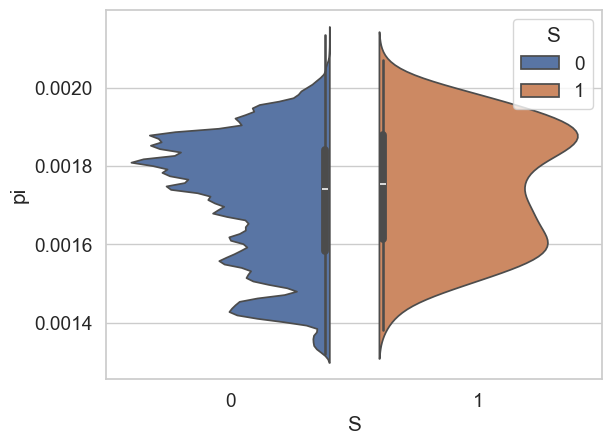

In [9]:
sns.violinplot(y="pi", x="S", hue="S", split=True, data=pi_proba)

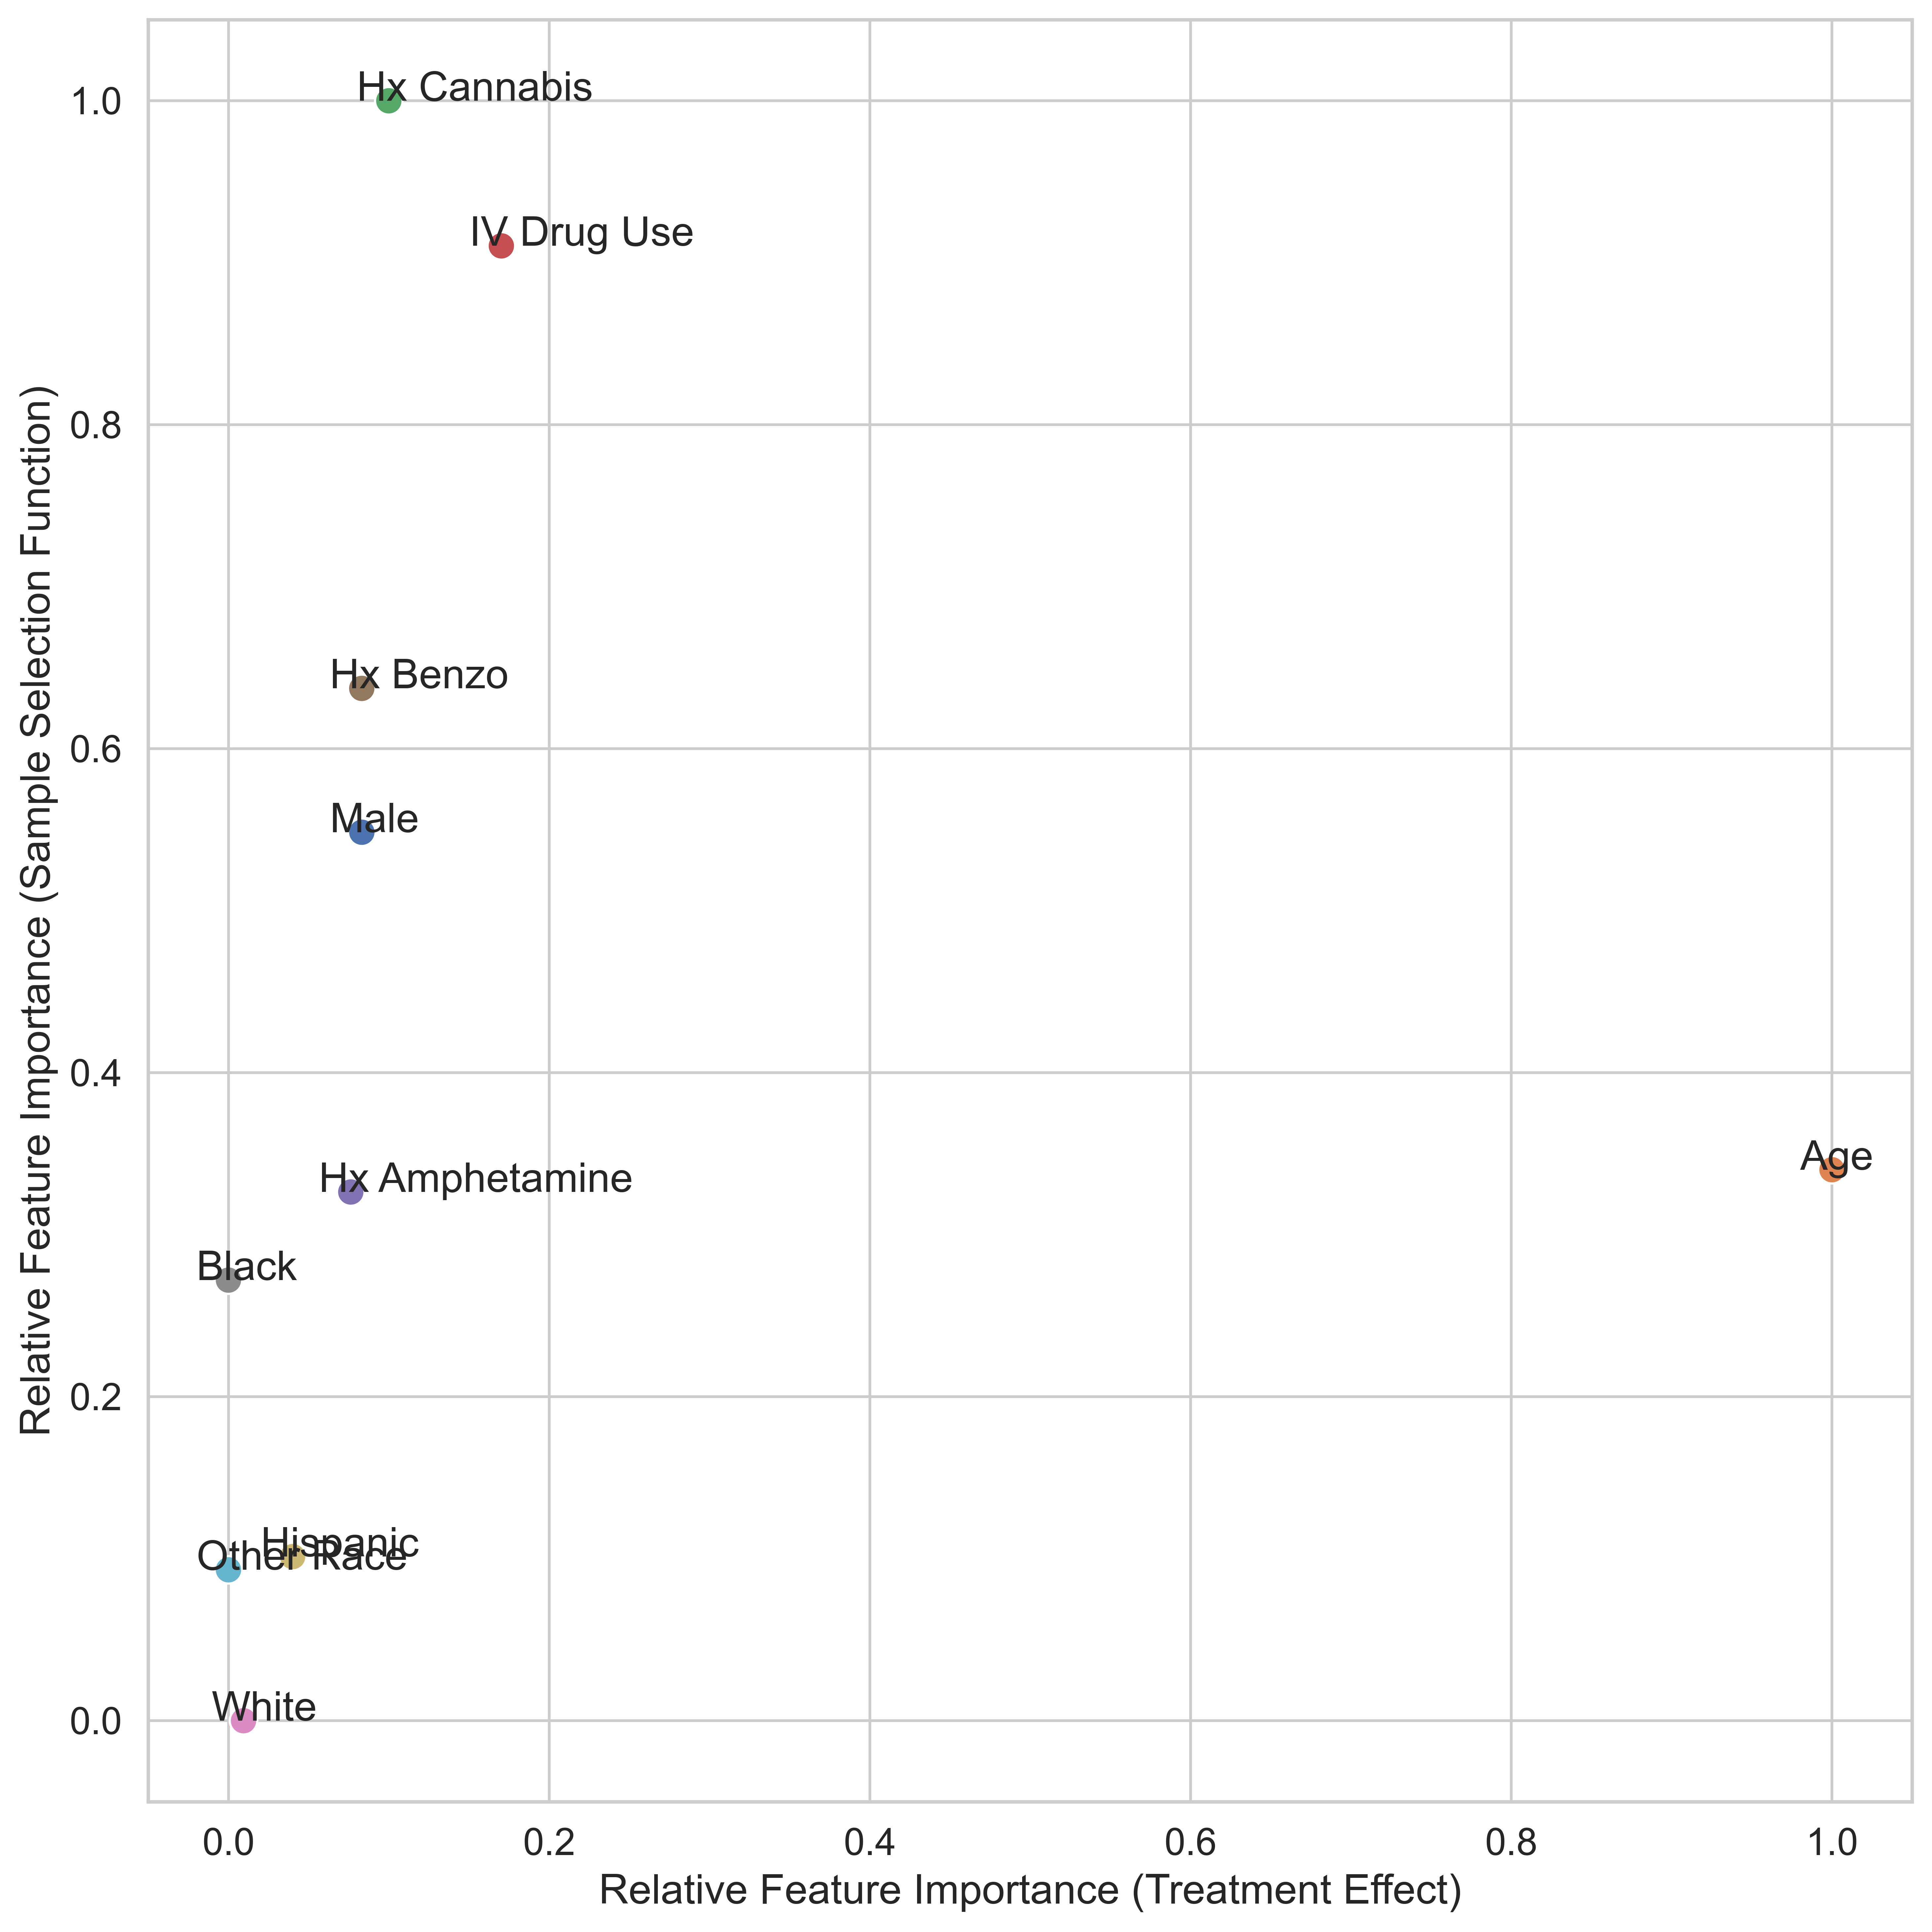

In [12]:
feature_imp = pd.DataFrame()
feature_imp["treatment effect"] = pd.Series(
    y1_m.feature_importances_ + y0_m.feature_importances_, index=X.columns
).abs()
feature_imp["sample"] = pd.Series(pi_m.coef_[0], index=X.columns).abs()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_imp_scaled = pd.DataFrame(
    scaler.fit_transform(feature_imp),
    columns=feature_imp.columns,
    index=feature_imp.index,
)


def label_point(data, x, y, val, ax):
    for i in data.index:
        ax.text(data.loc[i][x] - 0.02, data.loc[i][y], str(data.loc[i][val]))


fig, ax = plt.subplots(figsize=(10, 10), dpi=600)
sns.scatterplot(
    data=feature_imp_scaled.reset_index(),
    x="treatment effect",
    y="sample",
    hue="index",
    ax=ax,
    s=100,
    legend=False,
)
label_point(
    data=feature_imp_scaled.reset_index(),
    x="treatment effect",
    y="sample",
    val="index",
    ax=ax,
)
plt.xlabel("Relative Feature Importance (Treatment Effect)")
plt.ylabel("Relative Feature Importance (Sample Selection Function)")
# plt.legend(ncols=3, loc=(0, -0.35))
plt.tight_layout()
plt.savefig("feature_importance_synth_case.pdf")

In [13]:
joint_sim = pd.DataFrame(
    pjoint.sample(n_samples=750000, random_state=42), columns=joint.columns
).round(0)
X_sim = joint_sim[X.columns]

S_sim = np.random.binomial(1, pi_m.predict_proba(X_sim)[:, 1])
T_sim = np.random.binomial(1, e_m.predict_proba(X_sim)[:, 1])
Y_sim = T_sim * joint_sim["Y(1)"] + (1 - T_sim) * joint_sim["Y(0)"]

In [14]:
df_sim = X_sim.copy(deep=True)
df_sim["Y"] = Y_sim
df_sim["T"] = T_sim
df_sim["S"] = S_sim
df_sim.mean()

Male               0.587255
Age               38.059543
Hx Cannabis        0.114700
IV Drug Use        0.539735
Hx Amphetamine     0.064641
Hx Benzo           0.059320
White              0.656255
Black              0.149341
Hispanic           0.141083
Other Race         0.056200
Y                  0.696300
T                  0.415492
S                  0.001740
dtype: float64

Analyses

In [15]:
data = df_sim
treatment = "T"
outcome = "Y"
sample = "S"

In [16]:
importlib.reload(learn)
df_v_est, pi_est, pi_m_est, e_m_est, data2_est = learn.estimate_dml(
    data, outcome, treatment, sample
)

In [18]:
# print(
#     "RCT-ATE: %.2f ± %.2f"
#     % (
#         100
#         * (
#             data.loc[(data[sample] == 1) * (data[treatment] == 1), outcome].mean()
#             - data.loc[(data[sample] == 1) * (data[treatment] == 0), outcome].mean()
#         ),
#         100
#         * (
#             data.loc[(data[sample] == 1) * (data[treatment] == 1), outcome].sem()
#             + data.loc[(data[sample] == 1) * (data[treatment] == 0), outcome].sem()
#         ),
#     )
# )


print(
    "RCT-IPW ATE: %.2f ± %.2f" % (100 * df_v_est["a"].mean(), 100 * df_v_est["a"].sem())
)

print(
    "Transported ATE: %.2f ± %.2f"
    % (100 * df_v_est["te"].mean(), 100 * df_v_est["te"].sem())
)

RCT-IPW ATE: -22.45 ± 12.82
Transported ATE: -22.66 ± 12.93


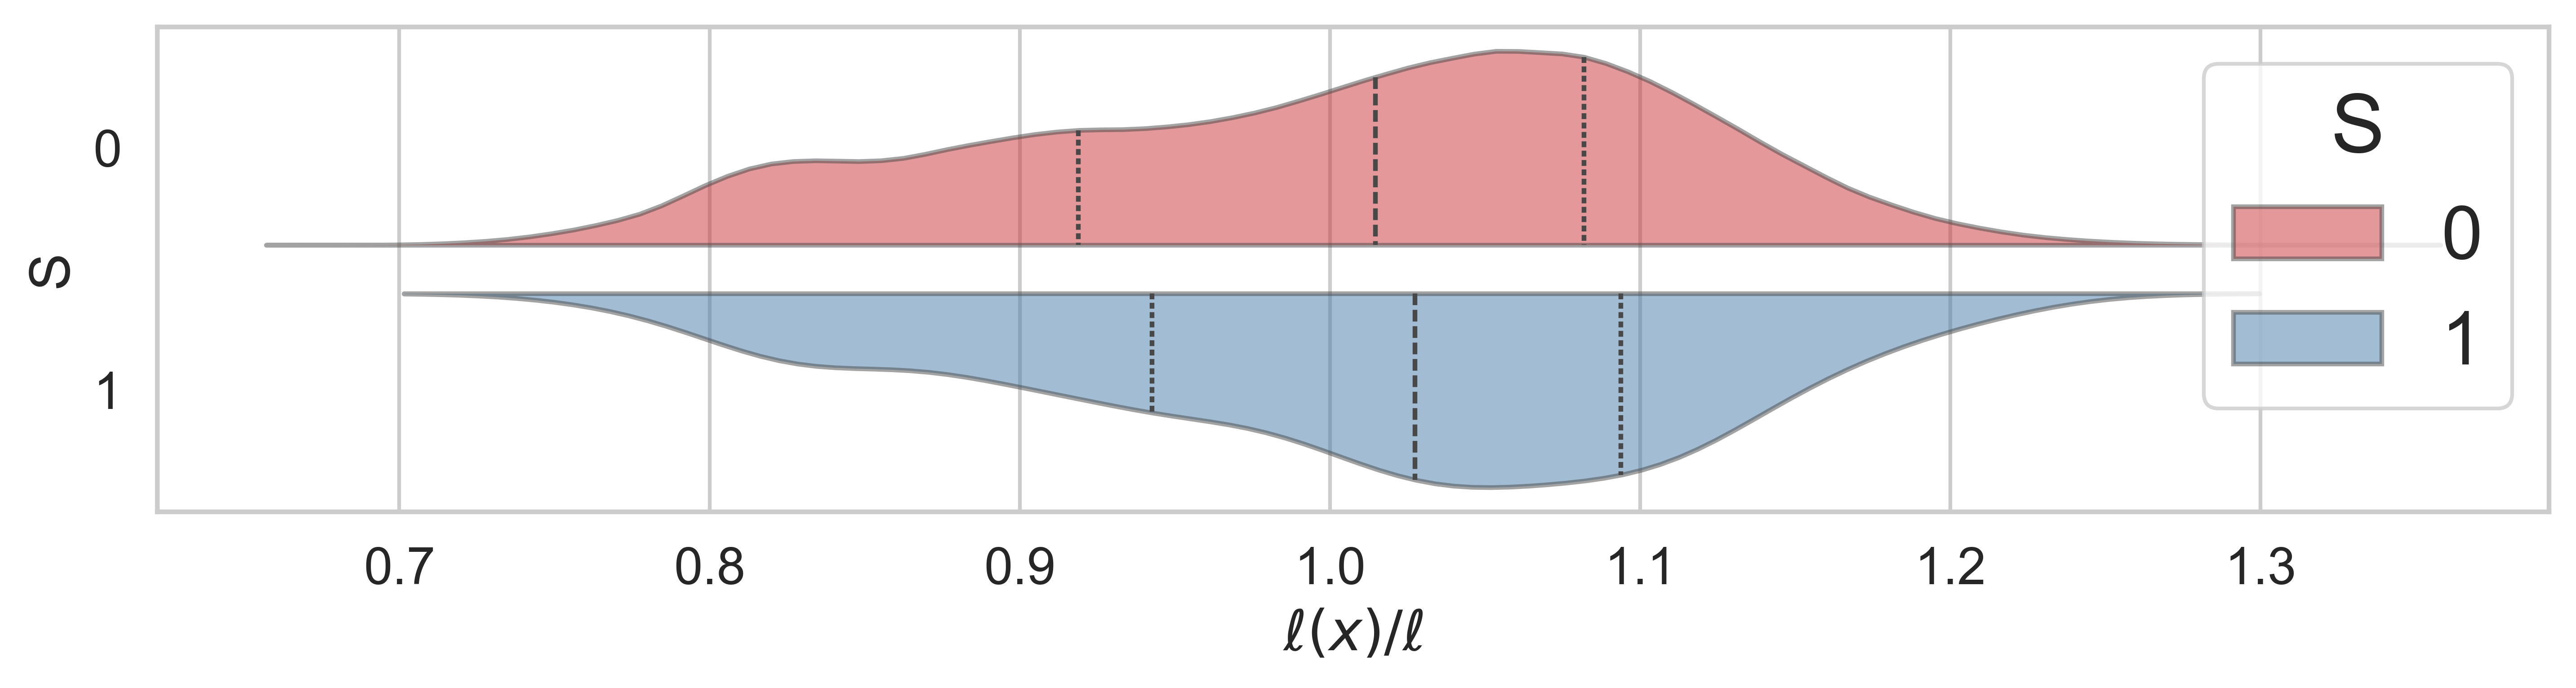

In [19]:
np.random.seed(42)
data_dummy_logit = data.copy(deep=True)
data_dummy_logit["pi(x)"] = pi_m_est.predict_proba(X_sim)[:, 1]
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="S",
    hue="S",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    # bw=0.25,
    palette="Set1",
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()

ATE Est: -0.0732
leaf              0.200000
Age               0.119387
Hx Benzo          0.125971
Hx Amphetamine    0.106873
IV Drug Use       0.008979
Hx Cannabis       0.015475
Male              0.203000
White             0.120840
Black             0.052193
Hispanic          0.030741
Other Race        0.016543
dtype: float64



KeyboardInterrupt



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12926084446366704
            Iterations: 11
            Function evaluations: 147
            Gradient evaluations: 11
(-22.660916111548044, 12.930951055363948)


[Text(0.5, 0.5, 'gini = 0.0\nsamples = 1305\nvalue = 1305.0')]

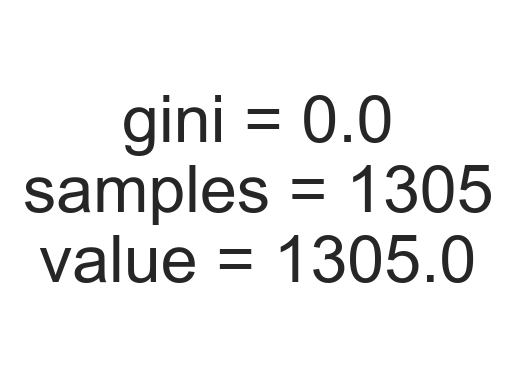

In [20]:
importlib.reload(learn)
np.random.seed(42)
D_linear, f_linear, _ = learn.linear_opt(
    data=data_dummy_logit,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
)
print(
    (
        100 * D_linear.loc[D_linear["w"].astype(int) == 1]["v"].mean(),
        100 * D_linear.loc[D_linear["w"].astype(int) == 1]["v"].sem(),
    )
)

tree.plot_tree(f_linear, feature_names=X_sim.columns)

(-26.65833896118056, 12.797105920373022)


[Text(0.5416666666666666, 0.875, 'Black <= 3.5\ngini = 0.072\nsamples = 1305\nvalue = [49, 1256]'),
 Text(0.3333333333333333, 0.625, 'Other Race <= 1.5\ngini = 0.041\nsamples = 1250\nvalue = [26, 1224]'),
 Text(0.16666666666666666, 0.375, 'Hispanic <= -5.5\ngini = 0.006\nsamples = 958\nvalue = [3, 955]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.25, 0.125, 'gini = 0.004\nsamples = 955\nvalue = [2, 953]'),
 Text(0.5, 0.375, 'Black <= -0.5\ngini = 0.145\nsamples = 292\nvalue = [23, 269]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.0\nsamples = 125\nvalue = [0, 125]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.238\nsamples = 167\nvalue = [23, 144]'),
 Text(0.75, 0.625, 'Other Race <= -0.5\ngini = 0.487\nsamples = 55\nvalue = [23, 32]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]'),
 Text(0.8333333333333334, 0.375, 'IV Drug Use <= 1.5\ngini = 0.438\nsamples = 34\nvalue = [23, 11]'),
 Text(0.75, 0.125, 'gini =

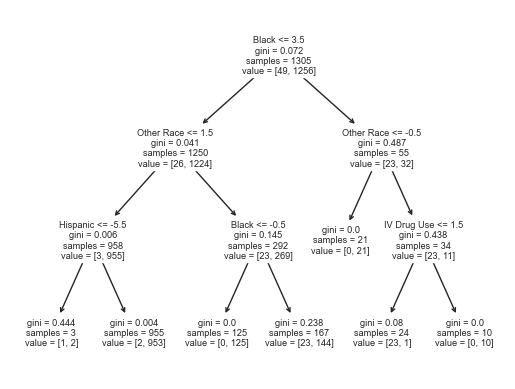

In [21]:
importlib.reload(learn)
np.random.seed(0)
D_tree, f_tree, _ = learn.tree_opt(
    data=data,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
)
print(
    (
        100 * D_tree.loc[D_tree["w"].astype(int) == 1]["v"].mean(),
        100 * D_tree.loc[D_tree["w"].astype(int) == 1]["v"].sem(),
    )
)

tree.plot_tree(f_tree, feature_names=X_sim.columns)

ATE Est: -0.2266
leaf              0.200000
Male              0.090468
Age               0.067997
Hx Cannabis       0.004155
IV Drug Use       0.039141
Hx Amphetamine    0.062554
Hx Benzo          0.153567
White             0.077406
Black             0.159791
Hispanic          0.010022
Other Race        0.134898
dtype: float64
(-38.39685615739853, 11.063825626142576)


[Text(0.5, 0.875, 'Age <= 46.5\ngini = 0.131\nsamples = 1305\nvalue = [92, 1213]'),
 Text(0.25, 0.625, 'Hx Benzo <= -4.5\ngini = 0.061\nsamples = 1012\nvalue = [32, 980]'),
 Text(0.125, 0.375, 'IV Drug Use <= 2.5\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.0625, 0.125, 'gini = 0.375\nsamples = 8\nvalue = [2, 6]'),
 Text(0.1875, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.375, 0.375, 'Black <= 1.5\ngini = 0.054\nsamples = 1002\nvalue = [28, 974]'),
 Text(0.3125, 0.125, 'gini = 0.029\nsamples = 755\nvalue = [11, 744]'),
 Text(0.4375, 0.125, 'gini = 0.128\nsamples = 247\nvalue = [17, 230]'),
 Text(0.75, 0.625, 'Black <= 3.5\ngini = 0.326\nsamples = 293\nvalue = [60, 233]'),
 Text(0.625, 0.375, 'Male <= 0.5\ngini = 0.307\nsamples = 275\nvalue = [52, 223]'),
 Text(0.5625, 0.125, 'gini = 0.206\nsamples = 129\nvalue = [15, 114]'),
 Text(0.6875, 0.125, 'gini = 0.378\nsamples = 146\nvalue = [37, 109]'),
 Text(0.875, 0.375, 'White <= -0.5\ngini = 0.494\nsamples = 18\nval

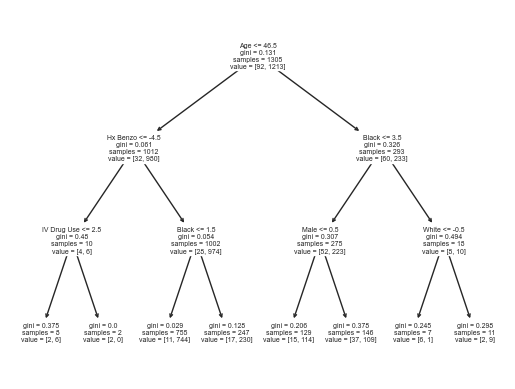

In [22]:
importlib.reload(learn)
np.random.seed(0)
D_rash, D_forest, w_forest, rashomon_set, f_forest, _ = learn.forest_opt(
    data=data,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    num_trees=1000,
    vote_threshold=9 / 10,
    explore_proba=0.1,
)
print(
    (
        100 * D_rash.loc[D_rash["w_opt"].astype(int) == 1]["v"].mean(),
        100 * D_rash.loc[D_rash["w_opt"].astype(int) == 1]["v"].sem(),
    )
)

tree.plot_tree(f_forest, feature_names=X_sim.columns)

In [23]:
joint

,Age,Hx Benzo,Hx Amphetamine,IV Drug Use,Hx Cannabis,Male,White,Black,Hispanic,Other Race,Y(1),Y(0)
967497,22,0,0,0,0,0,1,0,0,0,0,1
5470095,32,0,0,0,0,1,0,0,1,0,1,1
5233882,32,0,0,0,1,0,1,0,0,0,1,0
5138094,37,0,0,1,1,1,1,0,0,0,0,1
3876213,52,0,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1933,45,0,0,1,0,1,0,0,0,1,1,1
1934,42,0,0,1,0,1,0,0,1,0,1,1
1935,25,1,1,0,0,1,1,0,0,0,0,0
1936,36,0,0,0,1,1,1,0,0,0,0,1
